In [1]:
import numpy as np
import cv2
import pytesseract
import matplotlib.pyplot as plt

In [2]:
import cv2
import numpy as np
import pytesseract

def read_image(file_path):
    return cv2.imread(file_path)


def detect_text(cvImage, tesseract_path = None) -> str:
    default_tesseract_path = "C:/Program Files/Tesseract-OCR/tesseract.exe"
    if tesseract_path is None:
        pytesseract.pytesseract.tesseract_cmd = default_tesseract_path
    else:
        pytesseract.pytesseract.tesseract_cmd = tesseract_path
    # Vietnamese language
    config = '-l vie'
    text = pytesseract.image_to_string(cvImage, config=config)
    return text


def isgray(cvImage):
    return len(cvImage.shape) < 3


def convert_to_rgb(cvImage):
    if isgray(cvImage):
        return cvImage
    else:
        return cv2.cvtColor(cvImage, cv2.COLOR_BGR2RGB)


def grayscale(cvImage):
    if isgray(cvImage):
        return cvImage
    else:
        return cv2.cvtColor(cvImage, cv2.COLOR_BGR2GRAY)


def convert_to_binary(cvImage):
    # convert image to grayscale
    img = grayscale(cvImage)
    # adaptive thresholding
    return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)


def denoise(cvImage):
    # grayscale or color image
    if isgray(cvImage):
        return cv2.fastNlMeansDenoising(cvImage, h=10)
    else:
        return cv2.fastNlMeansDenoisingColored(cvImage, None, 10, 10, 7, 15)


def rotate(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)


def find_score(arr, angle):
    data = rotate(arr, angle)
    hist = np.sum(data, axis=1)
    score = np.sum((hist[1:] - hist[:-1]) ** 2)
    return hist, score


def deskew(cvImage):
    img = convert_to_binary(cvImage)
    delta = 0.5
    limit = 5
    angles = np.arange(-limit, limit+delta, delta)
    scores = []
    for angle in angles:
        hist, score = find_score(img, angle)
        scores.append(score)
    best_score = max(scores)
    best_angle = angles[scores.index(best_score)]
    # correct skew
    return rotate(cvImage, best_angle)

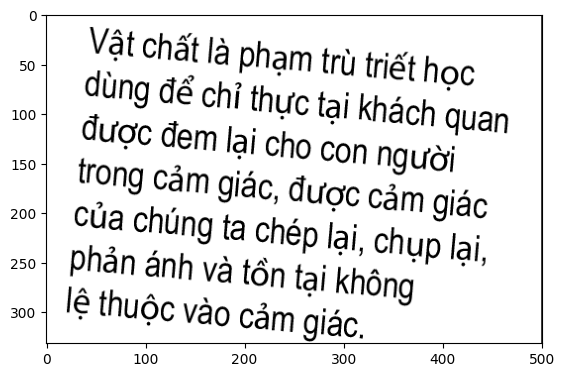

In [3]:
img = cv2.imread('img_test/skew.png')
plt.imshow(img)

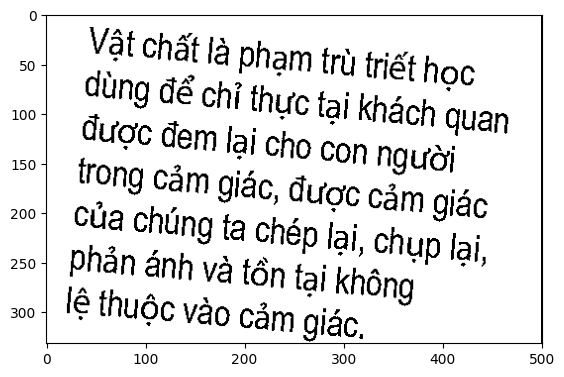

In [4]:
bin = convert_to_binary(img)
plt.imshow(bin, cmap='gray')

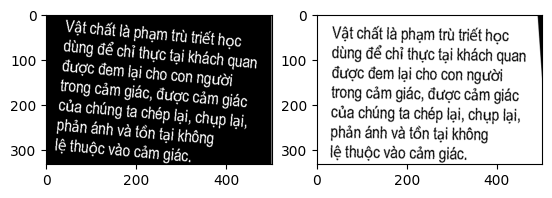

In [5]:
bin_img = 1 - bin/255
plt.subplot(1, 2, 1)

new = deskew(bin)
bin_new = 1 - new/255

plt.imshow(bin_img, cmap='gray')

plt.subplot(1,2, 2)
plt.imshow(new, cmap='gray')

Text(0.5, 0, '# of black pixels')

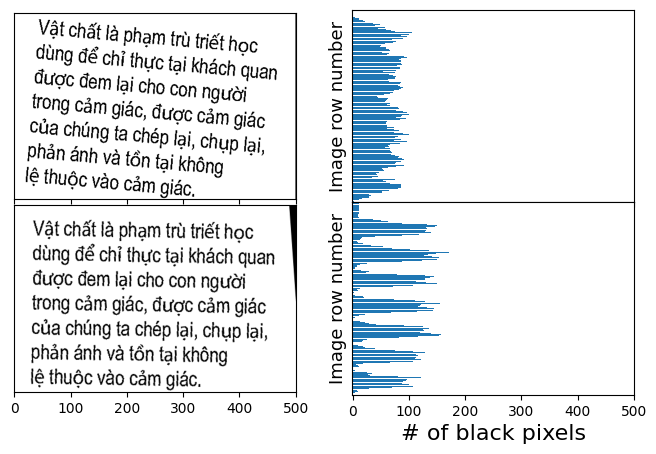

In [6]:

hist = np.sum(bin_img, axis=1)
hist_new = np.sum(bin_new, axis=1)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey=True)
f.subplots_adjust(hspace=0, wspace=0.2)

ax1.imshow(bin, cmap='gray')
ax2.barh(np.arange(bin_img.shape[0]), hist)
ax3.imshow(new, cmap='gray')
ax4.barh(np.arange(bin_new.shape[0]), hist_new)

ax1.set_yticks([])
ax3.set_yticks([])
ax2.axis('on')
ax4.axis('on')

ax2.set_ylabel('Image row number', fontsize=13)
ax4.set_ylabel('Image row number', fontsize=13)
ax4.set_xlabel('# of black pixels', fontsize=16)